# Olist : segmenter des clients d'un site e-commerce

## Sommaire

* [I. Préambule](#I)
    * [1. Contexte](#I1)
    * [2. Outils utilisés](#I2)
* [II. Chargement et premier aperçu des données](#II)
    * [1. Premier aperçu du jeu de données](#II1)
* [III. Analyse exploratoire des données](#III)
    * [1. Types de données](#III1)
    * [2. Valeurs manquantes](#III2)
    * [3. Recency, Frequency, Monetary (RFM)](#III3)
    * [4. Encodage des variables](#III4)
    * [5. Normalisation des données](#III5)

## I. Préambule<a class="anchor" id="I"></a>

### 1. Contexte<a class="anchor" id="I1"></a>

Je suis consultant pour Olist, une solution de vente sur les marketplaces en ligne. Olist souhaite que je fournisse à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Mon objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles. Je devrai fournir à l’équipe marketing une description actionable de ma segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

### 2. Outils utilisés<a class="anchor" id="I2"></a>

Nous allons utiliser le langage Python, et présenter ici le code, les résultats et l'analyse
sous forme de <a href='https://jupyter.org/'>Notebook Jupyter</a>.

Nous allons aussi utiliser les bibliothèques usuelles d'exploration et d'analyse de données,
afin d'améliorer la simplicité et la performance de notre code :
* <a href='https://numpy.org/'>NumPy</a> et <a href='https://pandas.pydata.org/'>Pandas</a> : effectuer des calculs scientifiques (statistiques, algèbre, ...) et manipuler des séries et tableaux de données volumineuses et complexes
* <a href='https://matplotlib.org/'>Matplotlib</a>, <a href='https://seaborn.pydata.org/'>Seaborn</a> et <a href='https://plotly.com/'>Plotly</a> : générer des graphiques lisibles, intéractifs et pertinents
* <a href='https://scikit-learn.org/stable/'>Scikit-learn</a> : effectuer le preprocessing des données

In [27]:
# Import libraries

# System libraries 
import os
import datetime

# Math libraries to process the data 
import numpy as np 
import pandas as pd

# Library for predictive data analysis
from sklearn.preprocessing import RobustScaler

# Graph libraries to produce graphs 
import matplotlib.pyplot as plt 
import seaborn as sns 

## II. Chargement et premier aperçu des données<a class="anchor" id="II"></a>

### 1. Premier aperçu du jeu de données<a class="anchor" id="II1"></a>

Nous allons charger les données en mémoire.

In [28]:
pd.set_option("display.max_column", 40)

In [29]:
# Load all the data
customers = pd.read_csv(
    "data/olist_customers_dataset.csv",
)

order_items = pd.read_csv(
    "data/olist_order_items_dataset.csv",
)

order_payments = pd.read_csv(
    "data/olist_order_payments_dataset.csv",
)

order_reviews = pd.read_csv(
    "data/olist_order_reviews_dataset.csv",
)

orders = pd.read_csv(
    "data/olist_orders_dataset.csv",
)

products = pd.read_csv(
    "data/olist_products_dataset.csv",
)

sellers = pd.read_csv(
    "data/olist_sellers_dataset.csv",
)

product_category_name = pd.read_csv(
    'data/product_category_name_translation.csv'
)

Maintenant que nos données sont importées nous allons observer de premières valeurs.

In [30]:
dataframe = pd.merge(orders, order_items, on='order_id', how='inner')
dataframe = pd.merge(dataframe, order_payments, on='order_id', how='inner')
dataframe = pd.merge(dataframe, order_reviews, on='order_id', how='inner')
dataframe = pd.merge(dataframe, products, on='product_id', how='inner')
dataframe = pd.merge(dataframe, customers, on='customer_id', how='inner')
dataframe = pd.merge(dataframe, sellers, on='seller_id', how='inner')
dataframe = pd.merge(dataframe, product_category_name, on='product_category_name', how='inner')

In [31]:
# Drop column product_category_name
dataframe = dataframe.drop(columns=["product_category_name"])

# Rename the column
dataframe.rename(columns={'product_category_name_english': 'product_category_name'}, inplace=True)

# Dataframe columns info
dataframe.info()

# Dataframe features
dataframe.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115609 non-null  object 
 1   customer_id                    115609 non-null  object 
 2   order_status                   115609 non-null  object 
 3   order_purchase_timestamp       115609 non-null  object 
 4   order_approved_at              115595 non-null  object 
 5   order_delivered_carrier_date   114414 non-null  object 
 6   order_delivered_customer_date  113209 non-null  object 
 7   order_estimated_delivery_date  115609 non-null  object 
 8   order_item_id                  115609 non-null  int64  
 9   product_id                     115609 non-null  object 
 10  seller_id                      115609 non-null  object 
 11  shipping_limit_date            115609 non-null  object 
 12  price                         

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2,voucher,1,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350,maua,SP,housewares
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,1,credit_card,3,37.77,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,40.0,268.0,4.0,500.0,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350,maua,SP,housewares
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,1,credit_card,1,37.77,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,40.0,268.0,4.0,500.0,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350,maua,SP,housewares


Le fichier de données contient 39 variables pour 115609 individus. Voyons quelle est la répartition des différentes variables.

In [6]:
# Dataframe variables description
dataframe.describe(include="all")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name
count,115609,115609,115609,115609,115595,114414,113209,115609,115609.000000,115609,115609,115609,115609.000000,115609.000000,115609.000000,115609,115609.000000,115609.000000,115609,115609.000000,13801,48906,115609,115609,115609.000000,115609.000000,115609.000000,115608.000000,115608.000000,115608.000000,115608.000000,115609,115609.000000,115609,115609,115609.000000,115609,115609,115609
unique,96516,96516,7,95989,88332,79241,93702,449,NaN,32171,3028,91386,NaN,NaN,NaN,4,NaN,NaN,96319,NaN,4477,35176,632,96163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93396,NaN,4093,27,NaN,604,23,71
top,895ab968e7bb0d5659d16cd74cd1650c,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-12-20 00:00:00,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,4a3ca9315b744ce9f8e9374361493884,2017-08-14 20:43:31,NaN,NaN,NaN,credit_card,NaN,NaN,eef5dbca8d37dfce6db7d7b16dd0525e,NaN,Recomendo,Muito bom,2017-12-19 00:00:00,2017-08-17 22:17:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9a736b248f67d166d2fbb006bcb877c3,NaN,sao paulo,SP,NaN,sao paulo,SP,bed_bath_table
freq,63,63,113210,63,63,63,63,649,NaN,533,2128,63,NaN,NaN,NaN,85278,NaN,NaN,63,NaN,489,253,531,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,NaN,18267,48797,NaN,28811,82417,11847
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.194535,NaN,NaN,NaN,120.619850,20.056880,1.093747,NaN,2.946233,172.387379,NaN,4.034409,NaN,NaN,NaN,NaN,48.766541,785.808198,2.205373,2113.907697,30.307903,16.638477,23.113167,NaN,35061.537597,NaN,NaN,24515.713958,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.685926,NaN,NaN,NaN,182.653476,15.836184,0.729849,NaN,2.781087,265.873969,NaN,1.385584,NaN,NaN,NaN,NaN,10.034187,652.418619,1.717771,3781.754895,16.211108,13.473570,11.755083,NaN,29841.671732,NaN,NaN,27636.640968,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.850000,0.000000,1.000000,NaN,0.000000,0.000000,NaN,1.000000,NaN,NaN,NaN,NaN,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,NaN,1003.000000,NaN,NaN,1001.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,39.900000,13.080000,1.000000,NaN,1.000000,60.870000,NaN,4.000000,NaN,NaN,NaN,NaN,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,NaN,11310.000000,NaN,NaN,6429.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,74.900000,16.320000,1.000000,NaN,2.000000,108.050000,NaN,5.000000,NaN,NaN,NaN,NaN,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,NaN,24241.000000,NaN,NaN,13660.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,134.900000,21.210000,1.000000,NaN,4.000000,189.480000,NaN,5.000000,NaN,NaN,NaN,NaN,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,NaN,58745.000000,NaN,NaN,28605.000000,NaN,NaN,NaN


## III. Analyse exploratoire des données<a class="anchor" id="III"></a>

### 1. Types de données<a class="anchor" id="III1"></a>

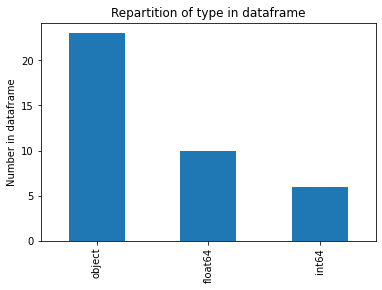

In [8]:
# Plot the dtypes in the dataframe
dataframe.dtypes.value_counts().plot.bar()

# Plot labeling
plt.ylabel('Number in dataframe')
plt.title('Repartition of type in dataframe');

Notre jeu de données d'entraînement contient 10 variables de type float, 6 integers et 23 objets.

### 2. Valeurs manquantes<a class="anchor" id="III2"></a>

<AxesSubplot:>

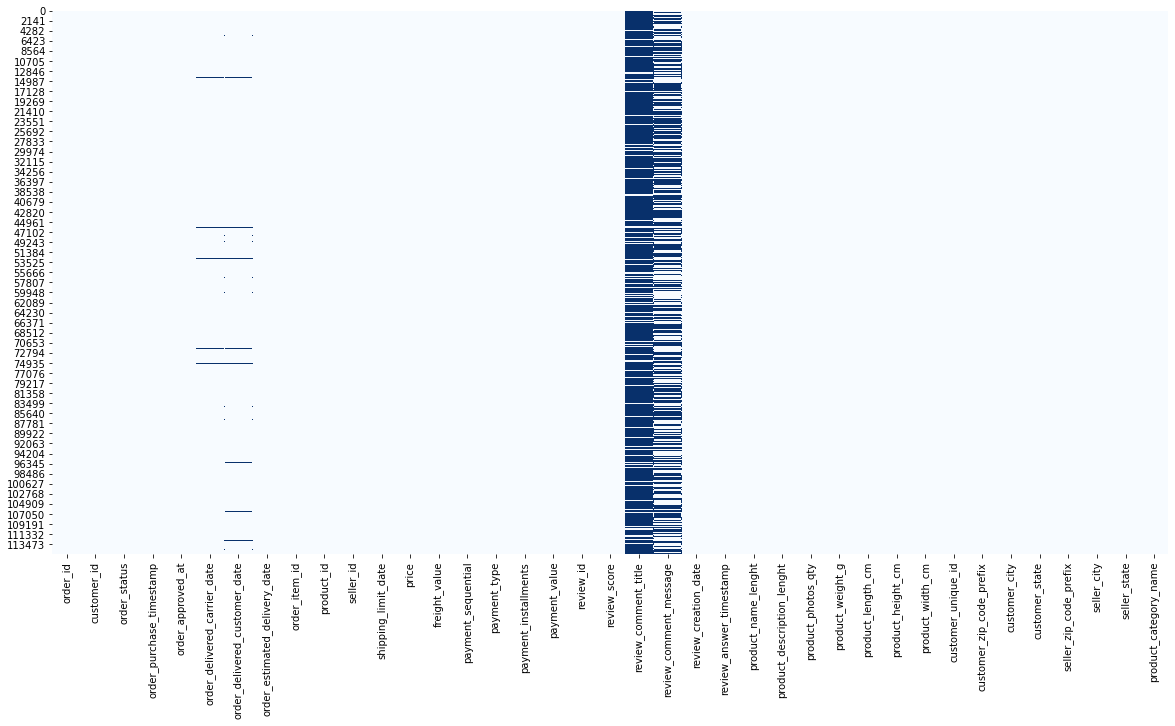

In [9]:
# Display the NaN values in a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(dataframe.isna(), cbar=False, cmap="Blues")

In [10]:
# Percentage of NaN in the dataframe
(dataframe.isna().sum()/dataframe.shape[0]).sort_values(ascending=False)

review_comment_title             0.880623
review_comment_message           0.576971
order_delivered_customer_date    0.020760
order_delivered_carrier_date     0.010337
order_approved_at                0.000121
product_height_cm                0.000009
product_weight_g                 0.000009
product_length_cm                0.000009
product_width_cm                 0.000009
review_answer_timestamp          0.000000
product_name_lenght              0.000000
product_description_lenght       0.000000
product_photos_qty               0.000000
order_id                         0.000000
review_creation_date             0.000000
customer_zip_code_prefix         0.000000
customer_city                    0.000000
customer_state                   0.000000
seller_zip_code_prefix           0.000000
seller_city                      0.000000
seller_state                     0.000000
customer_unique_id               0.000000
review_score                     0.000000
customer_id                      0

On voit ici que nous n'avons que 9 variables comportant des valeurs manquantes. Parmi elles, seules *review_comment_title* et *review_comment_message* contiennent 88% et 57% de NaN tandis que les autres en contiennent moins de 2%. Nous allons convertir les objets contenant des dates en objet datetime et combler les NaN de *order_delivered_carrier_date* et *order_delivered_customer_date* pour ensuite supprimer les autres variables avec des NaN ainsi que les colonnes dont nous n'allons pas nous servir.

In [32]:
# Convert type date columns from object to datetime64
dataframe['order_delivered_carrier_date'] = pd.to_datetime(dataframe['order_delivered_carrier_date'])
dataframe['order_delivered_customer_date'] = pd.to_datetime(dataframe['order_delivered_customer_date'])
dataframe['order_approved_at'] = pd.to_datetime(dataframe['order_approved_at'])
dataframe['order_purchase_timestamp'] = pd.to_datetime(dataframe['order_purchase_timestamp'])
dataframe['order_estimated_delivery_date'] = pd.to_datetime(dataframe['order_estimated_delivery_date'])
dataframe['review_answer_timestamp'] = pd.to_datetime(dataframe['order_approved_at'])
dataframe['review_creation_date'] = pd.to_datetime(dataframe['order_purchase_timestamp'])
dataframe['shipping_limit_date'] = pd.to_datetime(dataframe['shipping_limit_date'])

# Get the median of order_delivered_carrier_date column
delivered_carrier_median = pd.to_datetime(
    np.nanmedian([delivered_carrier.value for delivered_carrier in dataframe["order_delivered_carrier_date"]])
)

# Get the median order_delivered_customer_date 
delivered_customer_median = pd.to_datetime(
    np.nanmedian([delivered_customer.value for delivered_customer in dataframe["order_delivered_customer_date"]])
)

# Fill the NaN
dataframe['order_delivered_carrier_date'] = dataframe['order_delivered_carrier_date'].fillna(delivered_carrier_median)
dataframe['order_delivered_customer_date'] = dataframe['order_delivered_customer_date'].fillna(delivered_customer_median)

# Delete columns with NaN
dataframe = dataframe.drop(
    [
        "review_comment_message",  
        "review_comment_title",
        "order_approved_at",
        "product_width_cm",
        "product_weight_g",
        "product_length_cm",
        "product_height_cm",
        "customer_id",
        "order_item_id",
        "product_id",
        "seller_id",
        "review_id",
    ], axis=1
)

### 3. Recency, Frequency, Monetary (RFM)<a class="anchor" id="III3"></a>

Pour réaliser la segmentation de nos clients, nous allons utiliser le modeling RFM pour calculer le score RFM pour chaque client et ensuite appliquer un algorithme de machine learning non supervisé. Ici, **Recency** représente depuis combien de temps un client a acheté un article ou un produit. Plus les achats récents sont nombreux, meilleur le score sera. **Frequency** représente la fréquence à laquelle un client achète un article ou un produit, plus il achète fréquemment, meilleur sera le score pour la fréquence. Enfin, **Monetary** représente combien le client dépense, plus la dépense est importante, meilleur sera le score monétaire. Selon les règles métiers, une entreprise pourrait créer 3 groupes de segmentation différents : *High*, *Medium* et *Low*. 

- Un groupe marqué comme *High* est celui qui a les clients avec le plus haut score de **Frequency** et **Monetary**. Les clients de ce groupe viennent souvent sur le site de l'entreprise et dépensent plus que les autres groupes, c'est le groupe à ne pas perdre.
- Un groupe *Medium* visite souvent le site web mais pas aussi fréquemment que les clients du groupe *High*. Ils dépensent moins d'argent qu'eux et achètent moins souvent aussi. Les clients de ce groupe ont un score RFM moyen.
- Enfin, le groupe *Low* dans lequel nous avons des scores RFM bas. Les clients de ce groupe sont ceux qui n'ont pas acheté sur le site depuis un moment. En effet ils ne sont allés sur le site qu'une seule fois, peut-être pour échanger des coupons ou avoir des réductions. 

Nous allons donc maintenant attribuer les valeurs de RFM à partir des données que nous avons.

In [33]:
# Get the lastest date of purchase
snapshot_date = max(dataframe.order_purchase_timestamp) + datetime.timedelta(days=1)

# Create RFM modeling scores for each customer
rfm_score = dataframe.groupby("customer_unique_id").agg({
    "order_purchase_timestamp" : lambda x: (snapshot_date - x.max()).days,
    "order_id" : 'count',
    "payment_value" : "mean"
})

# Drop order_id column
dataframe = dataframe.drop(["order_id"], axis=1)

# Rename column names
rfm_score.columns = ["recency", "frequency", "monetary"]
rfm_score.describe(include="all", datetime_is_numeric=True)

,recency,frequency,monetary
count,93396.000000,93396.000000,93396.000000
mean,242.744250,1.237837,158.477932
std,153.164721,0.847540,217.326755
min,1.000000,1.000000,1.856818
25%,119.000000,1.000000,60.850000
50%,223.000000,1.000000,103.585000
75%,352.000000,1.000000,175.560000
max,729.000000,75.000000,13664.080000


Maintenant que nous avons les valeurs de notre RFM, observons la distribution de ces données.

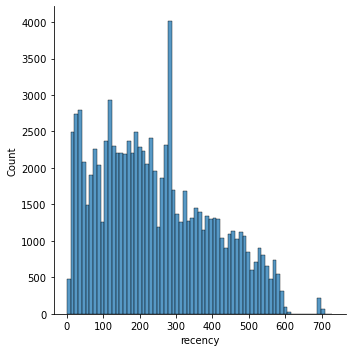

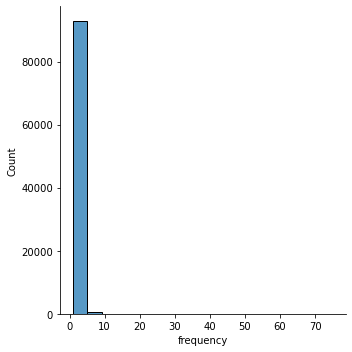

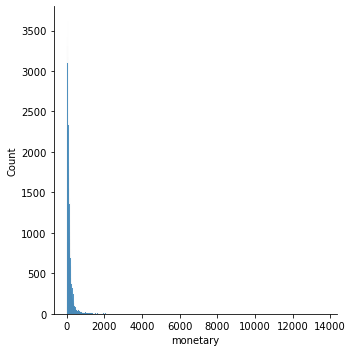

In [13]:
# Plot variable distributions
for column in rfm_score.columns:
    x = rfm_score[column]
    ax = sns.displot(x)

On remarque déjà que la **frequency** a souvent une valeur de 1.

In [34]:
# Split into four segments using quantiles
quantiles = rfm_score.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

# Functions to create R, F and M segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [38]:
# Show R, F and M segment values
rfm_score['R'] = rfm_score['recency'].apply(RScoring, args=('recency',quantiles,))
rfm_score['F'] = rfm_score['frequency'].apply(FnMScoring, args=('frequency',quantiles,))
rfm_score['M'] = rfm_score['monetary'].apply(FnMScoring, args=('monetary',quantiles,))

#Calculate RFM_group value column showing combined concatenated score of RFM
rfm_score['RFM_group'] = rfm_score.R.map(int) + rfm_score.F.map(int) + rfm_score.M.map(int)

#Calculate RFM_score value column showing total sum of RFM_group values
rfm_score['RFM_score'] = rfm_score[['R', 'F', 'M']].sum(axis = 1)

# Assign loyalty level tQ11o each customer
loyalty_level = ['Platinum', 'Gold', 'Silver', 'Bronze']
score_cuts = pd.qcut(rfm_score.RFM_score, q=4, labels=loyalty_level)
rfm_score['RFM_loyalty_level'] = score_cuts.values
rfm_score.reset_index().head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_group,RFM_score,RFM_loyalty_level
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,1,4,2,7,7,Platinum
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,1,4,4,9,9,Gold
2,0000f46a3911fa3c0805444483337064,542,1,86.22,4,4,3,11,11,Bronze
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,3,4,4,11,11,Bronze
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,3,4,1,8,8,Gold


In [39]:
# Export RFM dataframe
rfm_score.to_csv(r'data\rfm_dataframe_no_normalized.csv')

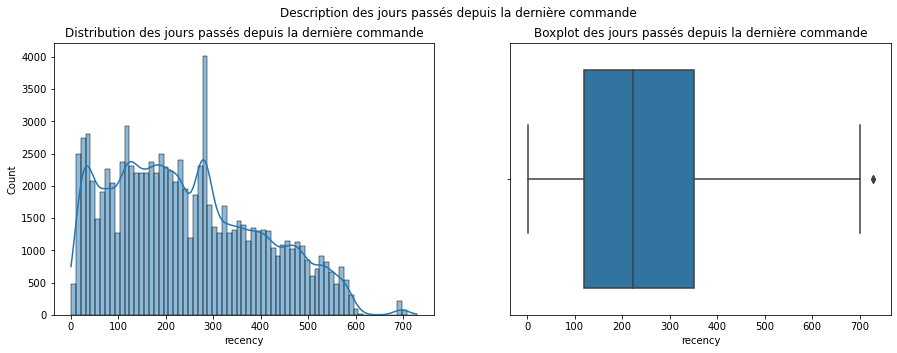

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des jours passés depuis la dernière commande')

sns.histplot(ax=axes[0], x="recency", data=rfm_score, kde=True)
axes[0].set_title("Distribution des jours passés depuis la dernière commande")

sns.boxplot(ax=axes[1], x="recency", data=rfm_score)
axes[1].set_title("Boxplot des jours passés depuis la dernière commande")

plt.show()

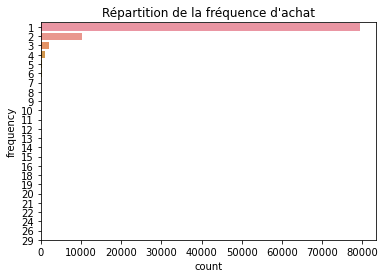

In [17]:
sns.countplot(y="frequency", data=rfm_score)
plt.ylim(23)
plt.title("Répartition de la fréquence d'achat")

plt.show()

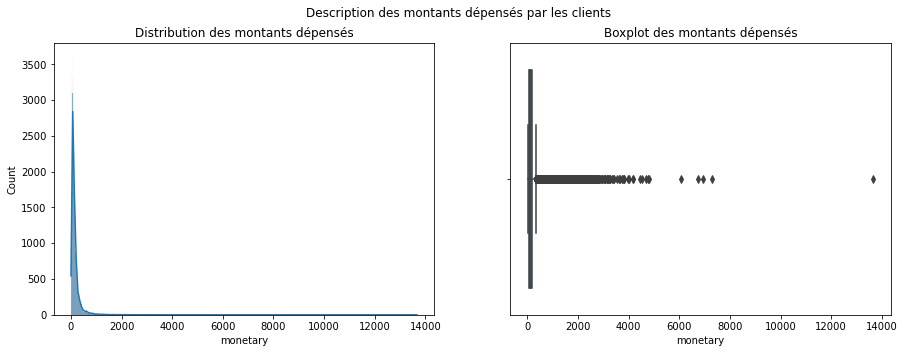

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des montants dépensés par les clients')

sns.histplot(ax=axes[0], x="monetary", data=rfm_score, kde=True)
axes[0].set_title("Distribution des montants dépensés")

sns.boxplot(ax=axes[1], x="monetary", data=rfm_score)
axes[1].set_title("Boxplot des montants dépensés")

plt.show()

**frequency** et **recency** ne semblent pas être très discriminants. En effet, la plupart des clients réalise un seul achat. De même, il est difficile de savoir s'ils reviennent régulièrement acheter donc **recency** est très variable. Les sommes dépensées (**monetary**) atteignent un maximum de 14.000 Réal.

En observant le fonctionnement du site, il s'avère que l'on peut commander sans avoir besoin de créer un compte. On ne peut donc pas savoir si une personne commande plusieurs fois et obtenir les informations nécessaires. Il pourrait être intéressant d'instaurer un système de compte pour obtenir des informations plus stables sur **recency** et **frequency**.

Nous allons fusionner nos dataframes afin de pouvoir les encoder.

In [20]:
# Merge dataframes
merged_dataframe = pd.merge(dataframe, rfm_score, on='customer_unique_id', how='inner')

In [26]:
merged_dataframe.to_csv(r'data\dataframe_no_normalize.csv', index=True)

### 4. Encodage des variables<a class="anchor" id="III4"></a>

Nous utiliserons le One-Hot Encoding pour toutes les variables catégorielles.

In [21]:
# Keep categorical features in an array
categorical_features = [feature for feature in merged_dataframe.select_dtypes("object") if feature != "customer_unique_id"]
categorical_features.append('RFM_loyalty_level')

# One-hot encoding of categorical variables
encoded_dataframe = pd.concat([merged_dataframe, pd.get_dummies(merged_dataframe[categorical_features])], axis=1).drop(categorical_features, axis=1)
encoded_dataframe = encoded_dataframe.set_index('customer_unique_id')

In [22]:
encoded_dataframe.shape

(115609, 4859)

### 5. Normalisation des données<a class="anchor" id="III5"></a>

Nous allons normaliser nos données afin de, plus tard, y appliquer des algorithmes d'apprentissage non-supervisé.

In [66]:
# Copy encoded dataframe without and with the datetime features
datetime_columns = [
    'order_purchase_timestamp', 
    'order_delivered_carrier_date', 
    'order_delivered_customer_date', 
    'order_estimated_delivery_date', 
    'shipping_limit_date',
    'review_answer_timestamp',
    'review_creation_date',
]
dataframe_without_datetime = encoded_dataframe.drop(datetime_columns, axis=1).copy()
dataframe_with_datetime = encoded_dataframe[datetime_columns].copy()

# Create list of column names
column_names = list(dataframe_without_datetime.columns)

# Normalize dataframe
normalized_data = RobustScaler().fit_transform(dataframe_without_datetime)

# Create new dataframe
data = pd.DataFrame(normalized_data, columns=column_names, index=dataframe_without_datetime.index)
data = data.merge(dataframe_with_datetime, right_index=True, left_index=True)

La normalisation a permis à nos variables d'avoir une médiane de 0 avec un écart-interquartile compris entre Q1 et Q3. Cette modification a pour but de rendre les modèles d'apprentissage non-supervisé comme l'algorithme K-means d'être plus performant.

Nous allons maintenant pouvoir exporter nos données.

In [68]:
# Delete columns with NaN
data = data.drop(
    [
        "review_answer_timestamp",  
    ], axis=1
)

data.to_csv(r'data\dataframe.csv', index=True)